In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt

file = 'data_set_ALL_AML_train.csv'
data = pd.read_csv(file, index_col=1)
key = pd.read_csv('actual.csv', index_col=0)

drop_list = ['call'] + ['call.' + str(x) for x in range(1,38)]
data = data.drop(columns=drop_list)

#Drop the 'Gene Description' row as it is not useful here
cleaned_data = data.drop(['Gene Description'], axis=1)
cleaned_data.columns = cleaned_data.columns.map(int)
print(cleaned_data.head())

#Transpose rows and columns so that each column is a different gene
transposed_data = cleaned_data.transpose()

#Merge the key dataframe with the trimmed dataframe to assign the cancer type to each patient sample
exp_data = pd.concat([key, transposed_data], axis=1, join='inner')

#Group by cancer type to aggregate and calculate mean and std for both cancer types
df_agg_trans = exp_data.groupby('cancer').agg(['mean', 'std'])
print(df_agg_trans.head())

                        1    2    3    4    5    6    7    8    9    10 ...   \
Gene Accession Number                                                   ...    
AFFX-BioB-5_at        -214 -139  -76 -135 -106 -138  -72 -413    5  -88 ...    
AFFX-BioB-M_at        -153  -73  -49 -114 -125  -85 -144 -260 -127 -105 ...    
AFFX-BioB-3_at         -58   -1 -307  265  -76  215  238    7  106   42 ...    
AFFX-BioC-5_at          88  283  309   12  168   71   55   -2  268  219 ...    
AFFX-BioC-3_at        -295 -264 -376 -419 -230 -272 -399 -541 -210 -178 ...    

                        35   36   37   38   28   29   30   31   32   33  
Gene Accession Number                                                    
AFFX-BioB-5_at           7 -213  -25  -72   -4   15 -318  -32 -124 -135  
AFFX-BioB-M_at        -100 -252  -20 -139 -116 -114 -192  -49  -79 -186  
AFFX-BioB-3_at         -57  136  124   -1 -125    2  -95   49  -37  -70  
AFFX-BioC-5_at         132  318  325  392  241  193  312  230  330  3

cancer                      ALL         AML     ALL:AML
AFFX-BioB-5_at mean -136.000000  -83.727273  -52.272727
               std   109.584881  105.120969  214.705850
AFFX-BioB-M_at mean -158.000000 -132.181818  -25.818182
               std    77.602538   71.018051  148.620589
AFFX-BioB-3_at mean  -19.555556  -11.272727   -8.282828
                 mean_diff     std_sum  correlation
AFFX-BioB-5_at  -52.272727  214.705850    -0.243462
AFFX-BioB-M_at  -25.818182  148.620589    -0.173719
AFFX-BioB-3_at   -8.282828  214.729078    -0.038573
AFFX-BioC-5_at -117.154882  203.102907    -0.576825
AFFX-BioC-3_at   -3.080808  230.890135    -0.013343


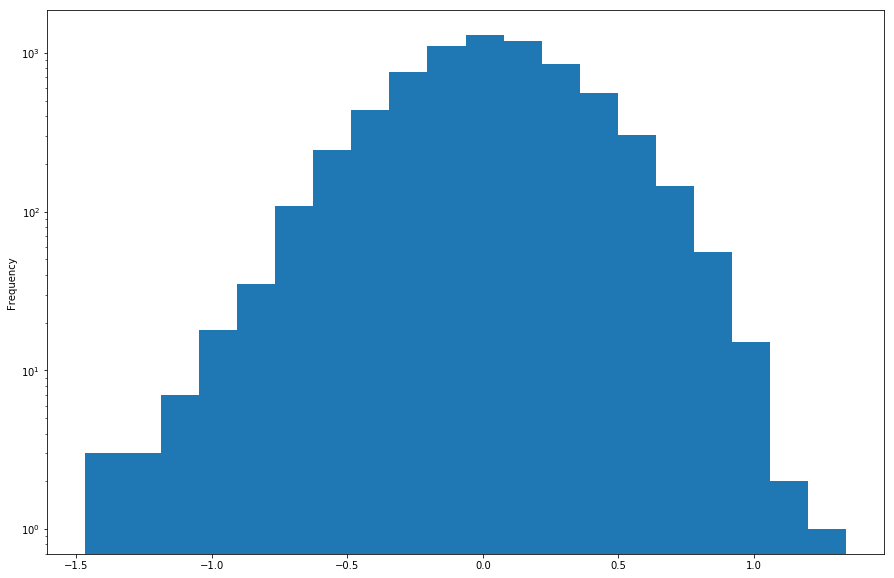

In [2]:
#Transpose dataframe so that genes form the rows
df_agg = df_agg_trans.transpose()

#Calculate the difference of ALL mean to AML mean for all genes
df_agg.loc[(slice(None), 'mean'), 'ALL:AML'] = (df_agg['ALL'] - df_agg['AML'])
df_agg.loc[(slice(None), 'std'), 'ALL:AML'] = (df_agg['ALL'] + df_agg['AML'])
print(df_agg.head())

mean_diff = df_agg.loc[(slice(None), 'mean'), 'ALL:AML']
mean_diff = mean_diff.reset_index(level=1)
mean_diff.drop(columns='level_1', inplace=True)
std_sum = df_agg.loc[(slice(None), 'std'), 'ALL:AML']
std_sum = std_sum.reset_index(level=1)
std_sum.drop(columns='level_1', inplace=True)

df_corr = pd.concat([mean_diff, std_sum], axis=1)
df_corr.columns = ['mean_diff', 'std_sum']

#Create a new column of the mean difference (mean_diff) over the standard deviation difference (std_diff) for each gene
df_corr.loc[:, 'correlation'] = (df_corr.mean_diff / df_corr.std_sum)
print(df_corr.head())

#Plot a histogram and line plot of the correlation for each gene
df_corr['correlation'].plot(kind='hist', bins=20, logy=True, figsize=(15,10))
plt.show()

In [3]:
#I want to concat the previous means dataframe so I can see the ALL_mean and AML_mean for each gene as well
#First, I will recreate the 'means' dataframe from earlier and rename the columns
means_both = df_agg.loc[(slice(None), 'mean'), 'ALL':'AML']
means_both.reset_index(level=1, inplace=True)
means_both.drop(columns='level_1', inplace=True)
means_both.columns = ['ALL_mean', 'AML_mean']

#Next I will do the same thing to slice out the standard deviations and rename the columns
stdev = df_agg.loc[(slice(None), 'std'), 'ALL':'AML']
stdev.reset_index(level=1, inplace=True)
stdev.drop(columns='level_1', inplace=True)
stdev.columns = ['ALL_stdev', 'AML_stdev']

#Finally, I will concat the df_corr, means_both, and stdev dataframes together into one dataframe
gene_summary = pd.concat([means_both, stdev, df_corr], axis=1)

#Filter dataset to include only the most highly correlated genes
top_genes = gene_summary[abs(gene_summary.correlation) > 0.861]
print(top_genes.head())
#Select the genes correlated with ALL cancer
top_genes_ALL = gene_summary[gene_summary.correlation >= 0.8]
#Select the genes correlated with AML cancer
top_genes_AML = gene_summary[gene_summary.correlation <= -0.9]

print(top_genes_ALL.correlation.sort_values())

                ALL_mean     AML_mean   ALL_stdev    AML_stdev    mean_diff  \
AF009426_at    67.851852   -49.000000   92.587050    33.790531   116.851852   
D49950_at      75.370370   243.909091   54.687327    93.180958  -168.538721   
J05243_at     867.629630   134.000000  627.050001   197.239955   733.629630   
L08246_at    1066.555556  3767.454545  668.587566  1941.522051 -2700.898990   
L13278_at     127.925926     0.545455   93.867716    30.559331   127.380471   

                 std_sum  correlation  
AF009426_at   126.377581     0.924625  
D49950_at     147.868285    -1.139790  
J05243_at     824.289956     0.890014  
L08246_at    2610.109616    -1.034784  
L13278_at     124.427047     1.023736  
U38846_at           0.800105
U49844_at           0.807122
U37055_rna1_s_at    0.811694
M63488_at           0.811765
X66401_cds1_at      0.813361
M11722_at           0.815784
U53468_at           0.816787
D38128_at           0.820144
M29540_at           0.823570
U62136_at           0.82

Index(['AF009426_at', 'D38128_at', 'D63874_at', 'D63880_at', 'D86967_at',
       'D88270_at', 'HG1612-HT1612_at', 'J03473_at', 'J05243_at', 'L13278_at',
       'L47738_at', 'M11722_at', 'M13792_at', 'M29540_at', 'M29696_at',
       'M31303_rna1_at', 'M63488_at', 'M77142_at', 'M86406_at', 'M91432_at',
       'M92287_at', 'S50223_at', 'U05259_rna1_at', 'U20998_at', 'U32944_at',
       'U33822_at', 'U35451_at', 'U38846_at', 'U49844_at', 'U53468_at',
       'U62136_at', 'U72342_at', 'X15414_at', 'X15949_at', 'X52142_at',
       'X56411_rna1_at', 'X59417_at', 'X63469_at', 'X66401_cds1_at',
       'X74262_at', 'X76648_at', 'Y08612_at', 'Z69881_at', 'D38073_at',
       'M61853_at', 'Z15115_at', 'AF012024_s_at', 'D26156_s_at',
       'U22376_cds2_s_at', 'U37055_rna1_s_at', 'M84371_rna1_s_at',
       'M31211_s_at', 'U09087_s_at', 'U26266_s_at', 'U90552_at',
       'X97267_rna1_s_at', 'L49229_f_at', 'M31523_at', 'M28170_at',
       'U29175_at'],
      dtype='object')


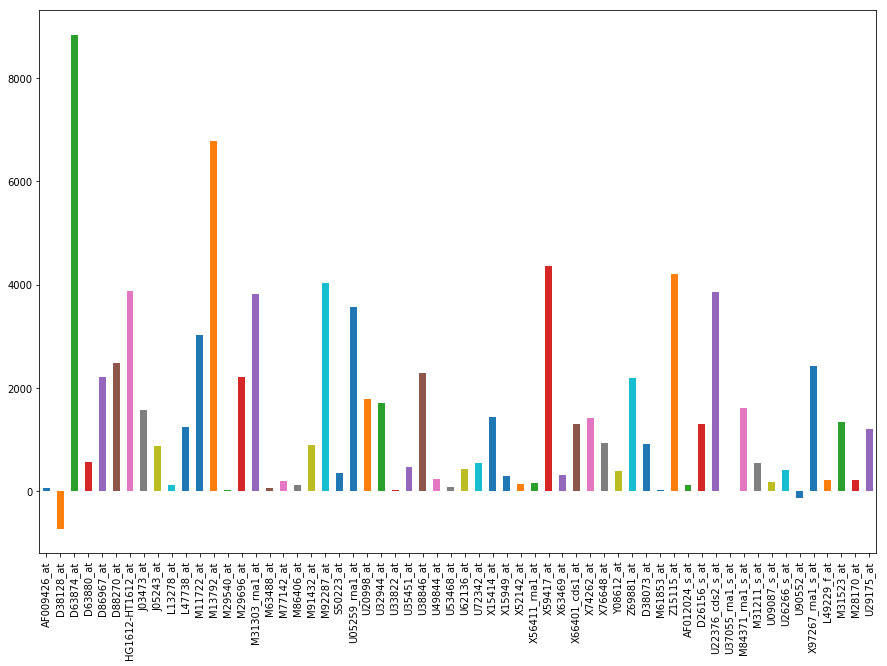

Index(['D49950_at', 'L08246_at', 'M11147_at', 'M16038_at', 'M21551_rna1_at',
       'M23197_at', 'M27891_at', 'M55150_at', 'M57710_at', 'M62762_at',
       'M63138_at', 'M69043_at', 'M80254_at', 'M81933_at', 'M84526_at',
       'M96326_rna1_at', 'U12471_cds1_at', 'U46751_at', 'U50136_rna1_at',
       'U82759_at', 'X04085_rna1_at', 'X17042_at', 'X95735_at', 'Y12670_at',
       'M28130_rna1_s_at', 'Y00787_s_at', 'M81695_s_at', 'M83652_s_at',
       'X85116_rna1_s_at', 'X58431_rna2_s_at', 'J03801_f_at', 'M19045_f_at',
       'X14008_rna1_f_at'],
      dtype='object')


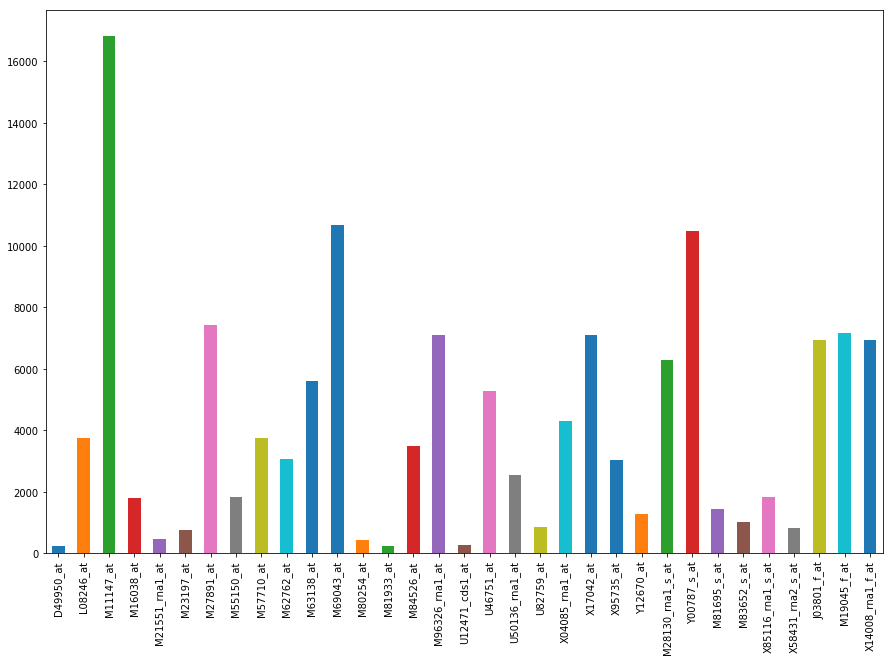

In [4]:
top_genes_ALL['ALL_mean'].plot(kind='bar', figsize=(15,10))
print(top_genes_ALL.index)
plt.show()
print(top_genes_AML.index)
top_genes_AML['AML_mean'].plot(kind='bar', figsize=(15,10))
plt.show()

['AF009426_at', 'D49950_at', 'J05243_at', 'L08246_at', 'L13278_at', 'L20941_at', 'L47738_at', 'M11147_at', 'M13792_at', 'M16038_at', 'M21551_rna1_at', 'M22960_at', 'M23197_at', 'M27891_at', 'M29696_at', 'M31303_rna1_at', 'M55150_at', 'M57710_at', 'M62762_at', 'M63138_at', 'M69043_at', 'M80254_at', 'M81933_at', 'M84526_at', 'M86406_at', 'M91432_at', 'M92287_at', 'M96326_rna1_at', 'S50223_at', 'U05259_rna1_at', 'U12471_cds1_at', 'U20998_at', 'U32944_at', 'U46751_at', 'U50136_rna1_at', 'U67963_at', 'U82759_at', 'X04085_rna1_at', 'X15949_at', 'X17042_at', 'X52142_at', 'X59417_at', 'X63469_at', 'X74262_at', 'X76648_at', 'X95735_at', 'Y08612_at', 'Y12670_at', 'Z69881_at', 'D38073_at', 'Z15115_at', 'D26156_s_at', 'U22376_cds2_s_at', 'M28130_rna1_s_at', 'Y00787_s_at', 'M31211_s_at', 'M81695_s_at', 'M83652_s_at', 'M98399_s_at', 'U09087_s_at', 'X85116_rna1_s_at', 'X58431_rna2_s_at', 'J03801_f_at', 'L49229_f_at', 'M19045_f_at', 'X14008_rna1_f_at', 'M31523_at', 'M28170_at', 'U29175_at']


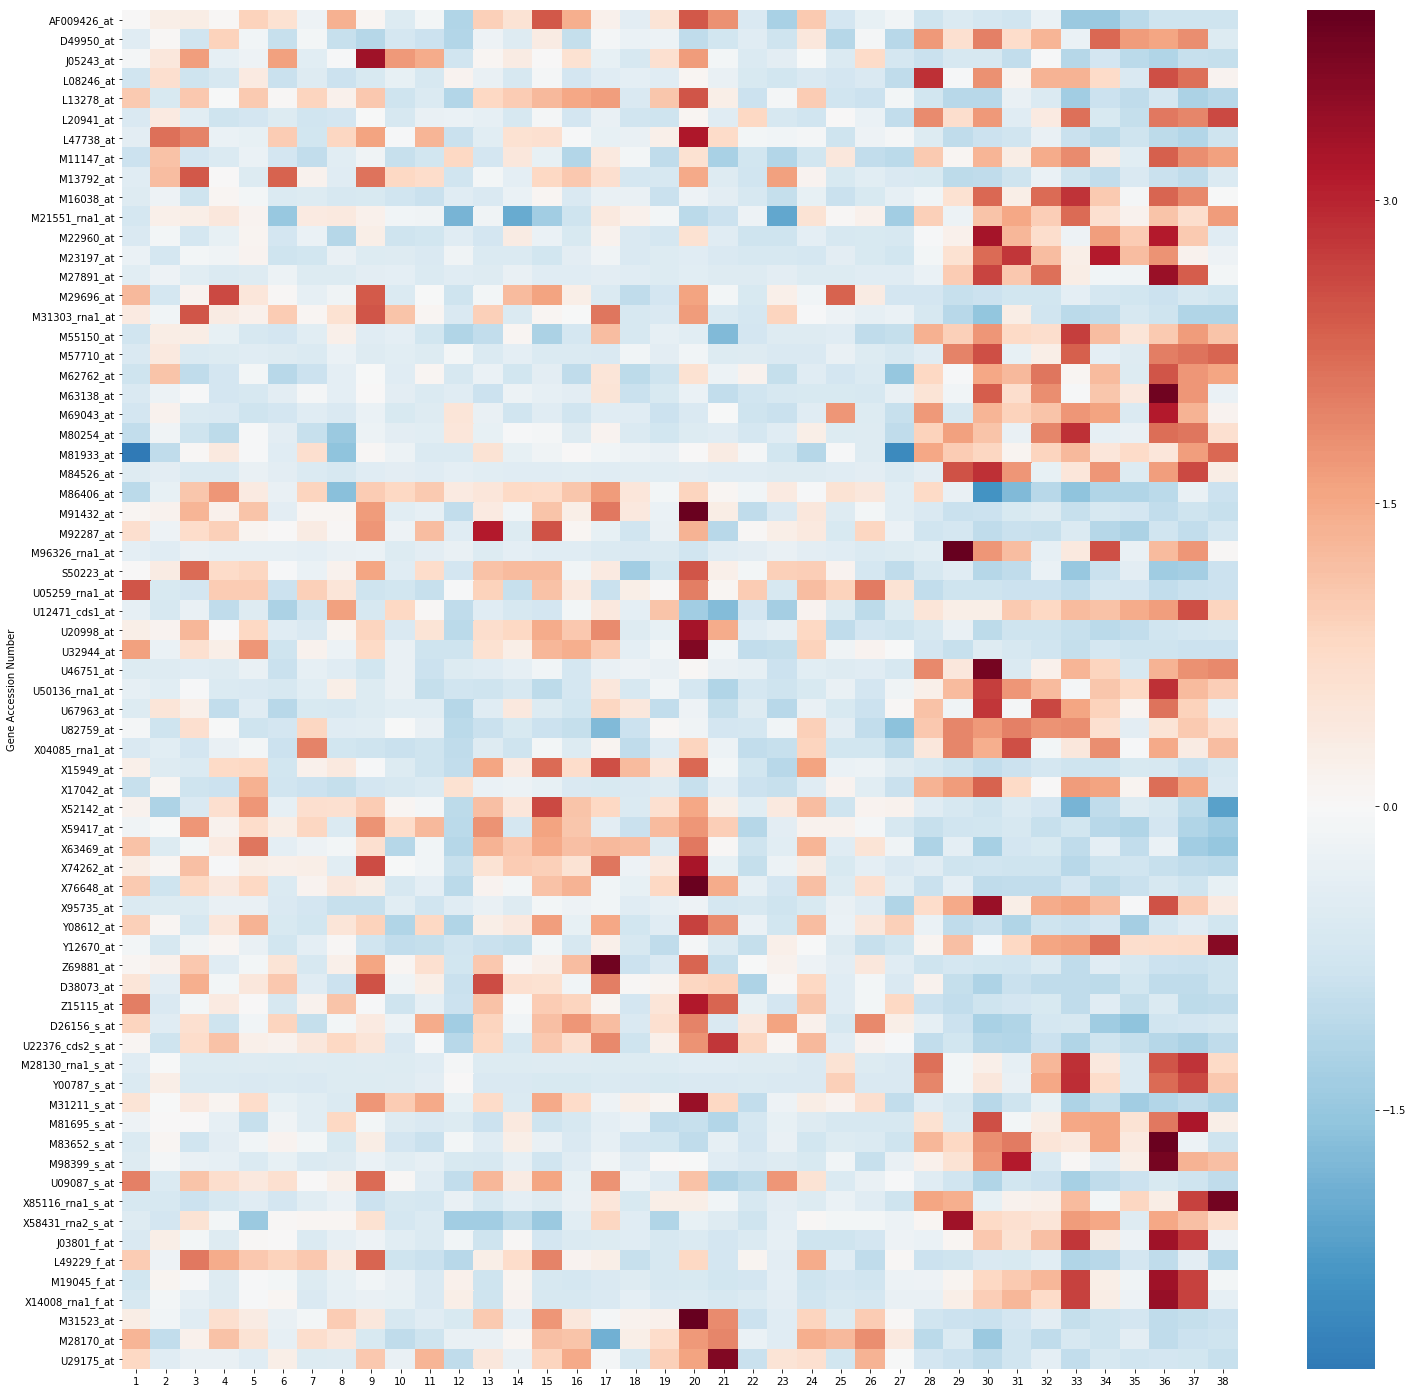

In [5]:
#Create a list with all of the top gene names
top_genes_list = list(top_genes.index)
print(top_genes_list)

#Select only the top genes from the original complete data set
data_top_genes = data.loc[top_genes_list]
#Drop the 'Gene Description' column
data_top_genes = data_top_genes.drop(columns='Gene Description')
#Make index numeric and sort the samples
data_top_genes.columns = data_top_genes.columns.map(int)
data_top_genes = data_top_genes.sort_index(axis=1)

#Merge with the top_genes dataframe to combine with ALL & AML means, standard deviations, and correlation calculations
gene_data = pd.concat([data_top_genes, top_genes], axis=1)

def normalize(df):
    #Normalize scales each gene to have values ranging from 0 to 1 across the ALL and AML samples
    norm_df = df
    for index, row in df.iterrows():
        norm_row = []
        for x in row:
            norm_value = ((x - row.min()) / (row.max() - row.min()))
            norm_row.append(norm_value)
        norm_df.loc[index] = norm_row
    return norm_df

def standardize(df):
    #Standardizes each gene
    stand_df = df
    for index, row in df.iterrows():
        stand_row = []
        for x in row:
            stand_value = (x - row.mean())/(row.std())
            stand_row.append(stand_value)
        stand_df.loc[index] = stand_row
    return stand_df

#Normalize the data
df_top_norm = normalize(data_top_genes)
df_top_stand = standardize(data_top_genes)

plt.figure(figsize=(25, 25))
#sns.clustermap(data_top_genes, z_score=0, figsize=(30, 20), cmap='RdBu_r', center=0)
sns.heatmap(df_top_norm, center=0, cmap='RdBu_r')
#sns.heatmap(df_top_stand, center=0, cmap='RdBu_r')
plt.show()

In [6]:
print(top_genes.correlation.sort_values())

M55150_at          -1.467641
U50136_rna1_at     -1.421708
X95735_at          -1.405770
M16038_at          -1.202917
M23197_at          -1.195974
M84526_at          -1.191039
Y12670_at          -1.184737
U82759_at          -1.164160
D49950_at          -1.139790
M27891_at          -1.109190
X17042_at          -1.105975
U12471_cds1_at     -1.069731
U46751_at          -1.064078
Y00787_s_at        -1.040985
L08246_at          -1.034784
M80254_at          -1.027711
M62762_at          -1.022852
M81933_at          -1.008193
M96326_rna1_at     -1.005372
M28130_rna1_s_at   -1.000917
M63138_at          -0.983628
M11147_at          -0.973952
M57710_at          -0.971289
M81695_s_at        -0.953066
X85116_rna1_s_at   -0.946113
M19045_f_at        -0.938076
X04085_rna1_at     -0.930499
M21551_rna1_at     -0.924241
M69043_at          -0.922509
X14008_rna1_f_at   -0.914954
                      ...   
M29696_at           0.865453
M86406_at           0.870867
M31303_rna1_at      0.875318
Y08612_at     

In [7]:
gene_list = ['L13278_at', 'U09087_s_at', 'M28170_at', 'X52142_at', 'AF009426_at', 'U20998_at', 'Z69881_at', 'J05243_at', 'L49229_f_at', 'Y08612_at', 
             'M31303_rna1_at', 'M86406_at', 'M29696_at', 'M13792_at', 'X76648_at', 'X15414_at', 'HG1612-HT1612_at', 
             'M84371_rna1_s_at', 'M77142_at', 'U26266_s_at', 'X56411_rna1_at', 'M61853_at', 'D63874_at', 'U35451_at']

gene_outliers = gene_summary.loc[gene_list]
gene_outliers['ALL_CV'] = (gene_outliers.ALL_stdev / gene_outliers.ALL_mean)*100
gene_outliers['AML_CV'] = (gene_outliers.AML_stdev / gene_outliers.AML_mean)*100
print(gene_outliers)
outliers_raw = cleaned_data.loc[gene_list].transpose()
print(outliers_raw)

                     ALL_mean     AML_mean    ALL_stdev    AML_stdev  \
L13278_at          127.925926     0.545455    93.867716    30.559331   
U09087_s_at        180.888889    46.909091   106.374640    25.719466   
M28170_at          210.111111   -21.272727   188.926997    54.770596   
X52142_at          143.296296   -70.727273   141.724493    87.623160   
AF009426_at         67.851852   -49.000000    92.587050    33.790531   
U20998_at         1786.777778   690.272727  1007.181457   216.456042   
Z69881_at         2196.370370   278.454545  1883.603771   269.310365   
J05243_at          867.629630   134.000000   627.050001   197.239955   
L49229_f_at        222.111111    21.545455   177.804848    49.750103   
Y08612_at          401.370370   185.363636   188.987413    57.179144   
M31303_rna1_at    3819.222222  1818.272727  1523.592221   762.377215   
M86406_at          123.777778  -161.454545   156.053081   171.473825   
M29696_at         2218.666667   472.727273  1785.253053   232.11

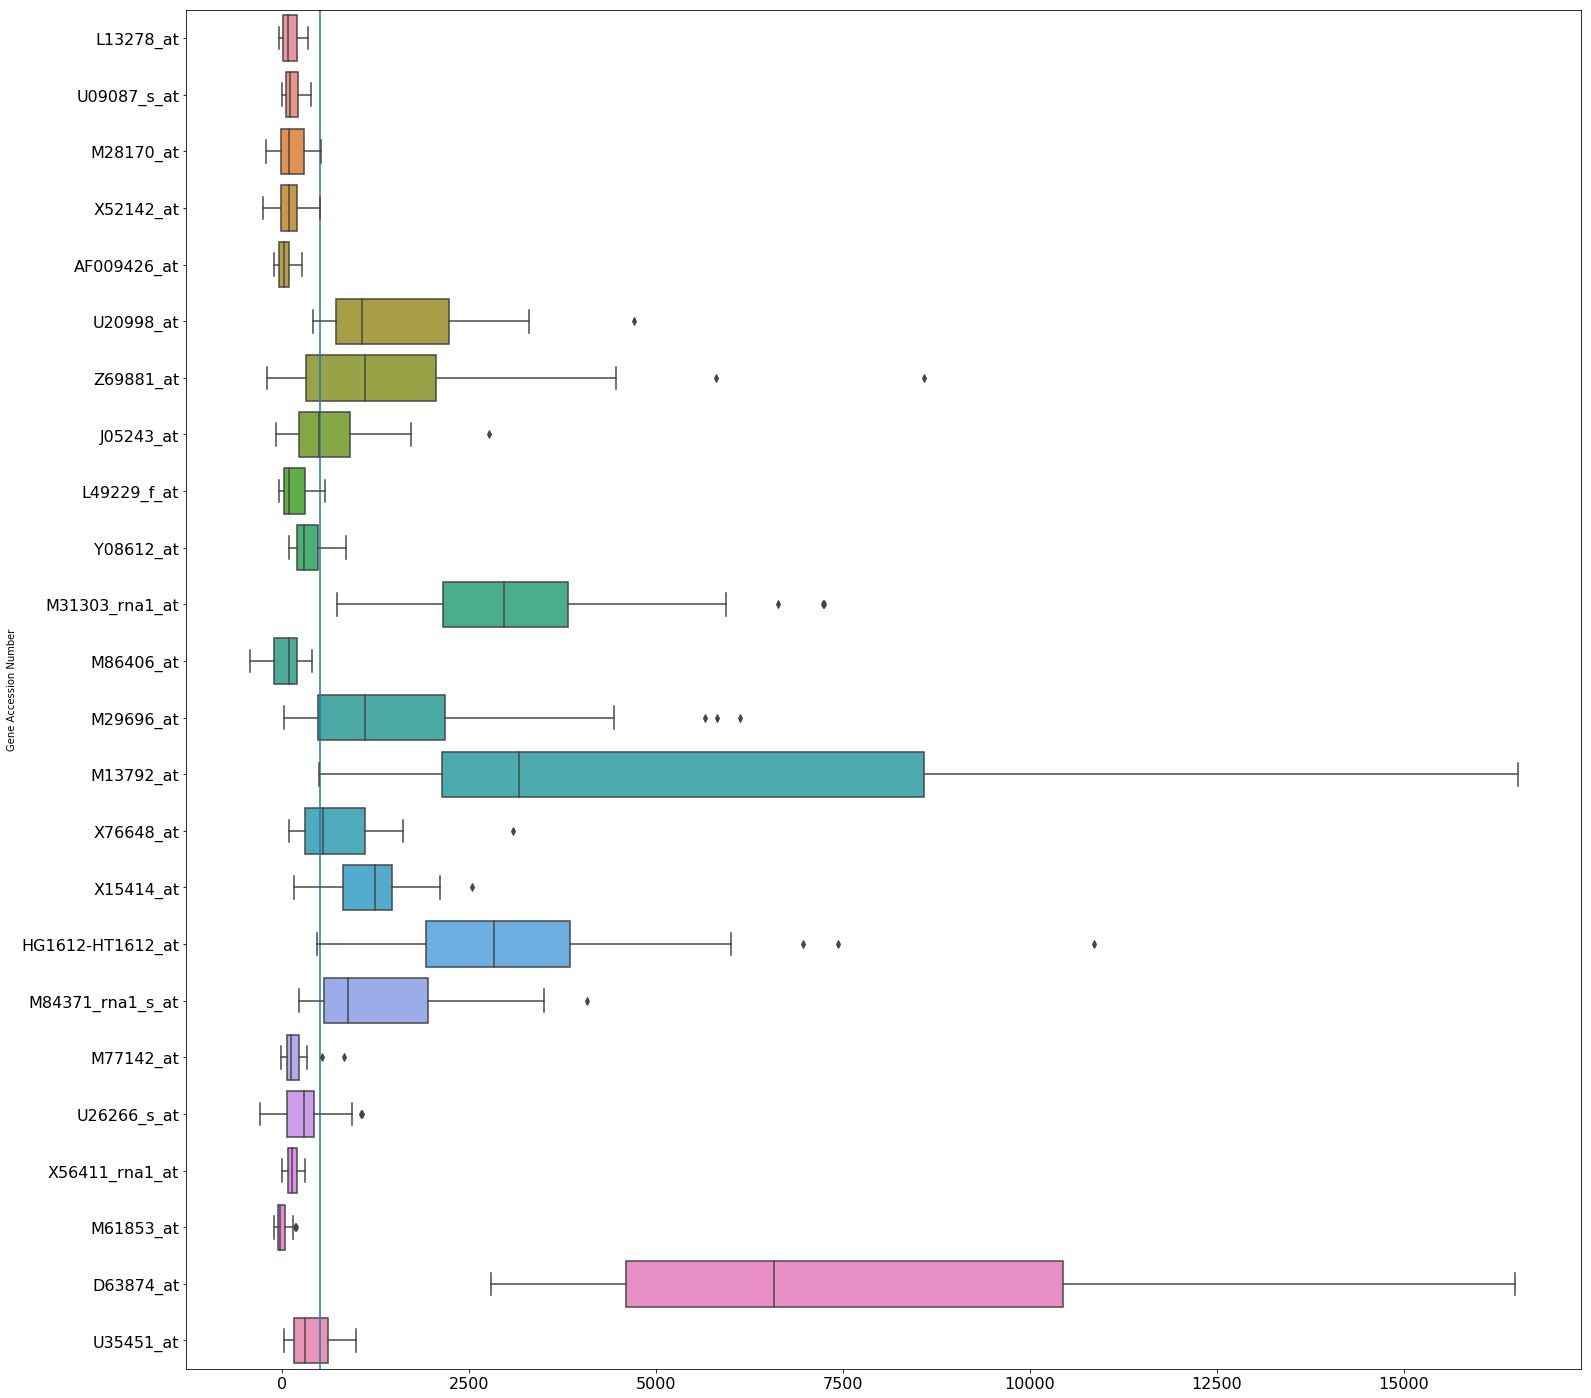

In [8]:
plt.figure(figsize=(25, 25))
plt.tick_params(axis='both', labelsize=16)
plt.axvline(x=500)
sns.boxplot(data=outliers_raw, orient='h')
plt.show()